## Seminar and homework (10 points total)

Today we shall compose encoder-decoder neural networks and apply them to the task of machine translation.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_


Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

## Our task: machine translation

We gonna try our encoder-decoder models on russian to english machine translation problem. More specifically, we'll translate hotel and hostel descriptions. This task shows the scale of machine translation while not requiring you to train your model for weeks if you don't use GPU.

Before we get to the architecture, there's some preprocessing to be done. ~~Go tokenize~~ Alright, this time we've done preprocessing for you. As usual, the data will be tokenized with WordPunctTokenizer.

However, there's one more thing to do. Our data lines contain unique rare words. If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence. This time we're gonna pick something inbetween.

One popular approach is called [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) aka __BPE__. The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [1]:
!pip3 install subword-nmt &> log
!wget https://github.com/yandexdataschool/nlp_course/raw/62c1410427385336ef2bea74b09cba39c956207d/week4_seq2seq/data.txt -O data.txt 2> log
!wget https://github.com/yandexdataschool/nlp_course/raw/62c1410427385336ef2bea74b09cba39c956207d/week4_seq2seq/utils.py -O utils.py 2> log
!wget https://github.com/yandexdataschool/nlp_course/raw/62c1410427385336ef2bea74b09cba39c956207d/week4_seq2seq/dummy_checkpoint.npz -O dummy_checkpoint.npz 2> log
#thanks to tilda and deephack teams for the data

In [8]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].segment(line.strip()) + '\n')

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into words.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [7]:
from utils import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [8]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
[[   0 2688 2943 1108   29    1    1    1]
 [   0 2922 1834 8035   59 3800   29    1]
 [   0 6030 2083   29    1    1    1    1]
 [   0 4927 1870   29    1    1    1    1]
 [   0 5549 1453   27  592   29    1    1]]

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


Draw source and translation length distributions to estimate the scope of the task.

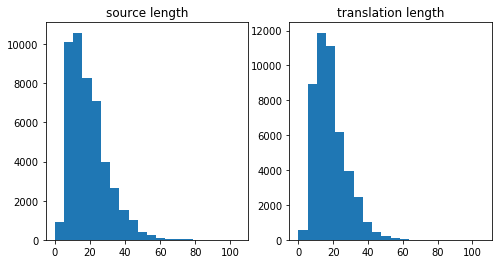

In [9]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model

The code below contas a template for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything. This model is implemented for you as a reference and a baseline for your homework assignment.

In [10]:
import tensorflow as tf
import keras.layers as L
from utils import infer_length, infer_mask

Using TensorFlow backend.


In [11]:
class BasicModel:
    def __init__(self, name, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder model
        """
        self.name, self.inp_voc, self.out_voc = name, inp_voc, out_voc

        with tf.variable_scope(name):
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(out_voc), emb_size)
            self.enc0 = tf.nn.rnn_cell.GRUCell(hid_size)

            self.dec_start = L.Dense(hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.logits = L.Dense(len(out_voc))

            # prepare to translate_lines
            self.inp = tf.placeholder('int32', [None, None])
            self.initial_state = self.prev_state = self.encode(self.inp)
            self.prev_tokens = tf.placeholder('int32', [None])
            self.next_state, self.next_logits = self.decode(self.prev_state, self.prev_tokens)
        
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_emb = self.emb_inp(inp)
        with tf.variable_scope('enc0'):
            _, enc_last = tf.nn.dynamic_rnn(
                              self.enc0, inp_emb,
                              sequence_length=inp_lengths,
                              dtype = inp_emb.dtype)
        dec_start = self.dec_start(enc_last)
        return [dec_start]

    def decode(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        [prev_dec] = prev_state
        prev_emb = self.emb_out(prev_tokens[:,None])[:,0]
        with tf.variable_scope('dec0'):
            new_dec_out, new_dec_state = self.dec0(prev_emb, prev_dec)
        output_logits = self.logits(new_dec_out)
        return [new_dec_state], output_logits

    def translate_lines(self, inp_lines, max_len=100):
        """
        Translates a list of lines by greedily selecting most likely next token at each step
        :returns: a list of output lines, a sequence of model states at each step
        """
        state = sess.run(self.initial_state, {self.inp: inp_voc.to_matrix(inp_lines)})
        outputs = [[self.out_voc.bos_ix] for _ in range(len(inp_lines))]
        all_states = [state]
        finished = [False] * len(inp_lines)

        for t in range(max_len):
            state, logits = sess.run([self.next_state, self.next_logits], {**dict(zip(self.prev_state, state)),
                                           self.prev_tokens: [out_i[-1] for out_i in outputs]})
            next_tokens = np.argmax(logits, axis=-1)
            all_states.append(state)
            for i in range(len(next_tokens)):
                outputs[i].append(next_tokens[i])
                finished[i] |= next_tokens[i] == self.out_voc.eos_ix
        return out_voc.to_lines(outputs), all_states

In [12]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
# ^^^ if you get "variable *** already exists": re-run this cell again - it will clear all tf operations youve 'built

model = BasicModel('model', inp_voc, out_voc)
sess.run(tf.global_variables_initializer())

### Training loss (2 points)

Our training objetive is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [13]:
def compute_logits(model, inp, out, **flags):
    """
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    :returns: logits of shape [batch, time, voc_size]
    
    * logits must be a linear output of your neural network.
    * logits [:, 0, :] should always predic BOS
    * logits [:, -1, :] should be probabilities of last token in out
    This function should NOT return logits predicted when taking out[:, -1] as y_prev
    """
    batch_size = tf.shape(inp)[0]
    
    # Encode inp, get initial state
    first_state = model.encode(inp)
    
    # initial logits: always predict BOS
    first_logits = tf.log(tf.one_hot(tf.fill([batch_size], model.out_voc.bos_ix),
                                     len(model.out_voc)) + 1e-30)
    
    # Decode step
    def step(prev_state, y_prev):
        # Given previous state, obtain next state and next token logits
        return model.decode(prev_state[0], y_prev)

    # You can now use tf.scan to run step several times.
    # use tf.transpose(out) as elems (to process one time-step at a time)
    # docs: https://www.tensorflow.org/api_docs/python/tf/scan
    
    outputs = tf.scan(step, tf.transpose(out), (first_state, first_logits))
    
    logits_seq = outputs[1]
    # prepend first_logits to logits_seq
    logits_seq = tf.concat((first_logits[None, ...], logits_seq[:-1]), axis=0)
    
    # Make sure you convert logits_seq from [time, batch, voc_size] to [batch, time, voc_size]
    logits_seq = tf.transpose(logits_seq, [1, 0, 2])
    return logits_seq

In [14]:
from utils import load
load(tf.trainable_variables(), 'dummy_checkpoint.npz')
dummy_inp = tf.constant(inp_voc.to_matrix(train_inp[:3]))
dummy_out = tf.constant(out_voc.to_matrix(train_out[:3]))
dummy_logits = sess.run(compute_logits(model, dummy_inp, dummy_out))
dummy_ref = np.array([-0.13257082, -0.11084784, -0.09024167, -0.14910498], dtype='float32')
assert np.allclose(dummy_logits.sum(-1)[0, 1:5], dummy_ref)
ref_shape = (dummy_out.shape[0], dummy_out.shape[1], len(out_voc))
assert dummy_logits.shape == ref_shape, "Your logits shape should be {} but got {}".format(ref_shape, dummy_logits.shape)
assert all(dummy_logits[:, 0].argmax(-1) == out_voc.bos_ix), "first step must always be BOS"

In [15]:
from utils import select_values_over_last_axis

def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use infer_length or infer_mask)
    """
    mask = infer_mask(out, out_voc.eos_ix)    
    logits_seq = compute_logits(model, inp, out, **flags)
    
    # Compute loss as per instructions above
    xent_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=out, logits=logits_seq)

    return tf.reduce_sum(xent_loss * mask) / tf.reduce_sum(mask)

In [16]:
dummy_loss = sess.run(compute_loss(model, dummy_inp, dummy_out))
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss, 8.425, rtol=0.1, atol=0.1), "We're sorry for your loss"

Loss: 8.424398


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [17]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
    translations, _ = model.translate_lines(inp_lines, **flags)
    # Note: if you experience out-of-memory error, split input lines into batches and translate separately
    return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [18]:
compute_bleu(model, dev_inp, dev_out)

4.764888431368293

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [54]:
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])

loss = compute_loss(model, inp, out)

train_step = tf.train.AdamOptimizer().minimize(loss)

In [55]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

sess.run(tf.global_variables_initializer())
batch_size = 128

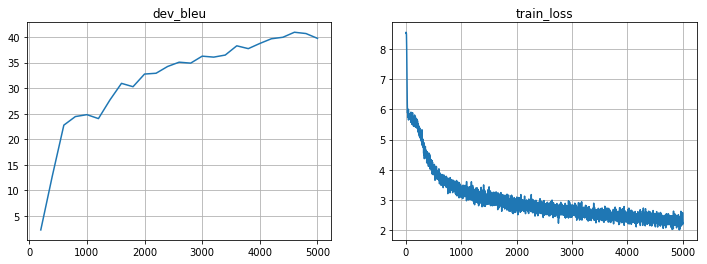

Mean loss=2.315


100%|██████████| 5000/5000 [09:47<00:00,  8.51it/s]


In [56]:
for _ in trange(5000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 200 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [57]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 35, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [59]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
a shared kitchen is available in the room .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
the property offers free shuttle service and car hire .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the nearest airport is elefthérios venizélos airport , 14 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in the centre of rome , a 10 - minute walk from the beach , the property offers a garden with a terrace and a terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
located in the centre of rome , this apartment is 600 metres from the beach .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the private bathroom comes with a shower .



### Your Attention Required (4 points)

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the leture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

In [19]:
class AttentionLayer:
    def __init__(self, name, enc_size, dec_size, hid_size, activ=tf.tanh,):
        """ A layer that computes additive attention response and weights """
        self.name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity

        with tf.variable_scope(name):
            self.linear_enc = L.Dense(hid_size)
            self.linear_dec = L.Dense(hid_size)
            self.linear_out = L.Dense(1)

    def __call__(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        with tf.variable_scope(self.name):
            key = self.linear_enc(enc)
            query = self.linear_dec(dec)[:, None, :]
            logits = self.linear_out(self.activ(key + query))[..., 0]
            
            
            # Apply mask - if mask is 0, logits should be -inf or -1e9
            # You may need tf.where
            logits = inp_mask * logits + (1 - inp_mask) * (-1e9)
            
            # Compute attention probabilities (softmax)
            probs = tf.nn.softmax(logits)
            
            # Compute attention response using enc and probs
            attn = tf.reduce_sum(probs[..., None] * enc, axis=1)
            
            return attn, probs

### Seq2seq model with attention

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attetion layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [134]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128, encoder_num_layers=3, encoder_direction='bidirectional', cell='gru'):
        """ Translation model that uses attention. See instructions above. """
        self.name = name
        self.inp_voc = inp_voc
        self.out_voc = out_voc

        with tf.variable_scope(name):
            
            # YOUR CODE - define model layers
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(out_voc), emb_size)
            
            if cell == 'gru':
                self.encoder = tf.contrib.cudnn_rnn.CudnnGRU(encoder_num_layers, hid_size, direction=encoder_direction)
            elif cell == 'rnn_relu':
                self.encoder = tf.contrib.cudnn_rnn.CudnnRNNRelu(encoder_num_layers, hid_size, direction=encoder_direction)
            elif cell == 'rnn_tanh':
                self.encoder = tf.contrib.cudnn_rnn.CudnnRNNTanh(encoder_num_layers, hid_size, direction=encoder_direction)
            self.attention = AttentionLayer('attention_layer0', hid_size, hid_size, attn_size)
            self.dec_start = L.Dense(hid_size)
            if cell == 'gru':
                self.decoder = tf.nn.rnn_cell.GRUCell(hid_size)
            else:
                self.decoder = tf.nn.rnn_cell.BasicRNNCell(hid_size, activation=tf.nn.relu if cell == 'rnn_relu' else tf.nn.tanh)
            self.proj = L.Dense(len(out_voc))
            # END OF YOUR CODE
            
            # prepare to translate_lines
            self.inp = tf.placeholder('int32', [None, None])
            self.initial_state = self.prev_state = self.encode(self.inp)
            self.prev_tokens = tf.placeholder('int32', [None])
            self.next_state, self.next_logits = self.decode(self.prev_state, self.prev_tokens)

        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        print(inp)
        # encode input sequence, create initial decoder states
        x = self.emb_inp(inp)
        with tf.variable_scope('encoder'):
            x, (enc_last,) = self.encoder(tf.transpose(x, [1, 0, 2]))
        x = tf.transpose(x, [1, 0, 2])
        enc_last = tf.reshape(tf.transpose(enc_last, [1, 0, 2]), (-1, enc_last.get_shape().as_list()[0] * enc_last.get_shape().as_list()[-1]))
        dec_start = self.dec_start(enc_last)
        mask = infer_mask(inp, self.out_voc.eos_ix)
        
        # apply attention layer from initial decoder hidden state
        _, first_attn_probas = self.attention(x, dec_start, mask)
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        first_state = (dec_start, x, mask, first_attn_probas)
        return first_state

    def decode(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch,n_tokens]
        """
        x = self.emb_out(prev_tokens)
        # Unpack your state: you will get tensors in the same order that you've packed in encode
        dec_prev_state, encoder_out, encoder_mask, prev_attn_probas = prev_state
        
        
        # Perform decoder step
        # * predict next attn response and probas given previous decoder state
        # * use prev tokens and next attn response to update decoder states
        # * predict logits
        
        next_attn_response, next_attn_probas = self.attention(encoder_out, dec_prev_state, encoder_mask)
        decoder_input = tf.concat((next_attn_response, x), axis=-1)
        with tf.variable_scope('decoder'):
            new_dec_out, dec_new_state = self.decoder(decoder_input, dec_prev_state)
        output_logits = self.proj(new_dec_out)
            
        # Pack new state:
        # * replace previous decoder state with next one
        # * copy encoder sequence and mask from prev_state
        # * append new attention probas
        next_state = (dec_new_state, encoder_out, encoder_mask, next_attn_probas)
        return next_state, output_logits


In [25]:
# WARNING! this cell will clear your TF graph from the regular model. All trained variables will be gone!
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel('model_attn', inp_voc, out_voc)

/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Tensor("model_attn/Placeholder:0", shape=(?, ?), dtype=int32)


### Training attentive model

We'll reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

In [26]:
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])

loss = compute_loss(model, inp, out)
train_step = tf.train.AdamOptimizer().minimize(loss)

Tensor("Placeholder:0", shape=(?, ?), dtype=int32)


In [28]:
from IPython.display import clear_output
from tqdm import tqdm, trange

metrics = {'train_loss': [], 'dev_bleu': []}
sess.run(tf.global_variables_initializer())
batch_size = 128

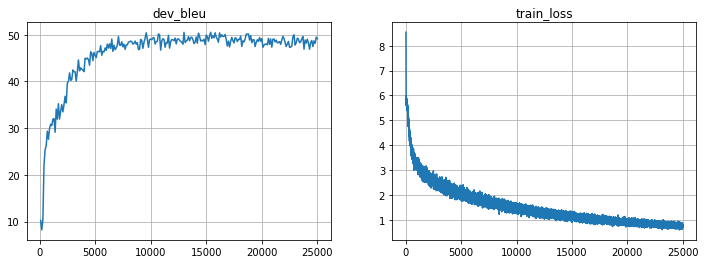

Mean loss=0.761


100%|██████████| 25000/25000 [1:05:05<00:00,  6.40it/s]


In [29]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp[:128], dev_out[:128])))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Your model may train slower than the basic one. check that it's at least >30 bleu by 5k steps
# Also: you don't have to train for 25k steps. It was chosen by a squirrel.

In [30]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 45, "Something might be wrong with the model..."

In [115]:
import seaborn as sns
import pandas as pd

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    df = pd.DataFrame(probs[:len(trans_tokens), :len(inp_tokens)])
    df.index = trans_tokens
    df.columns = inp_tokens
    sns.heatmap(df)
    plt.show()

In [116]:
inp = dev_inp[::200]

trans, states = model.translate_lines(inp)

# select attention probs from model state (you may need to change this for your custom model)
attention_probs = np.stack([state[-1] for state in states], axis=1)

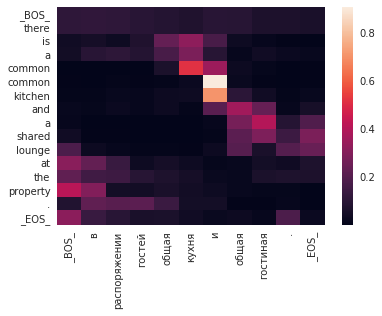

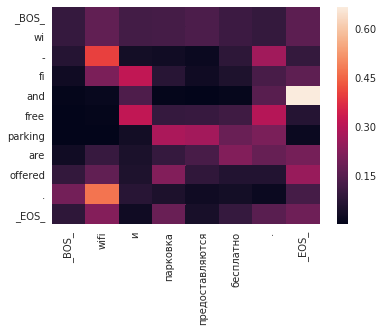

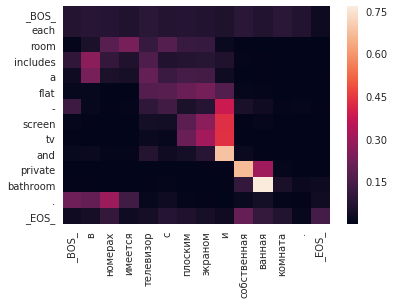

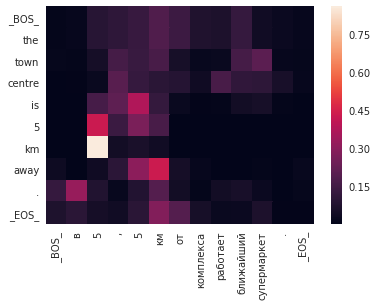

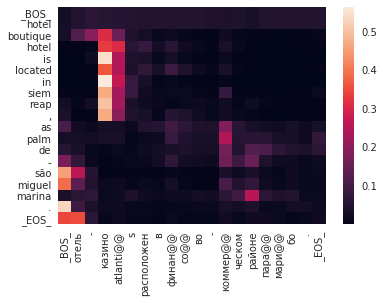

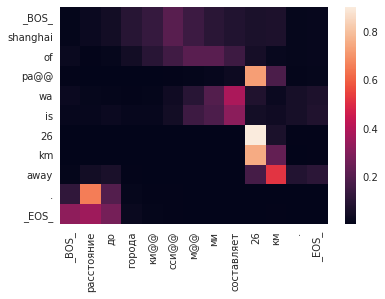

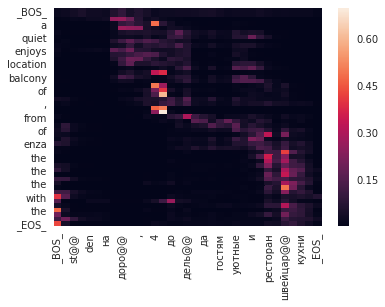

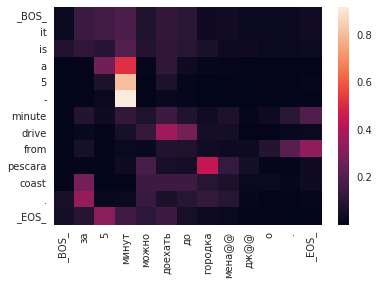

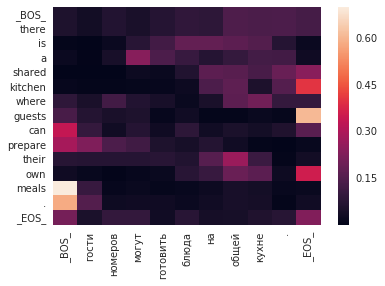

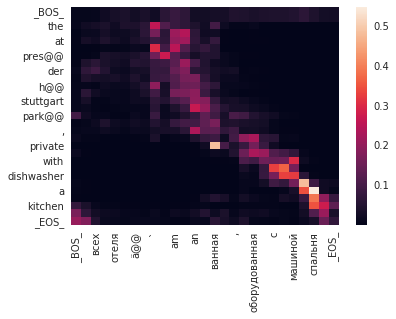

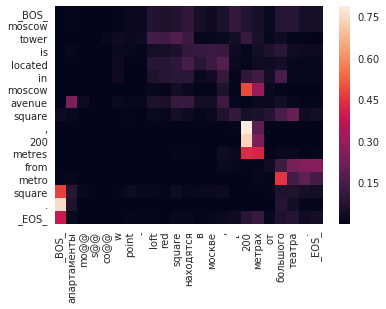

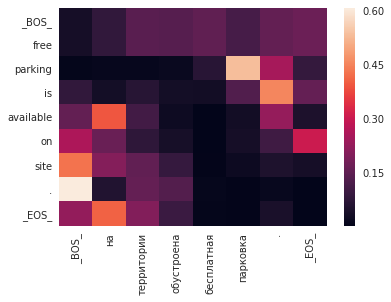

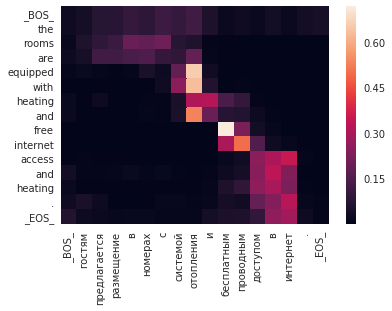

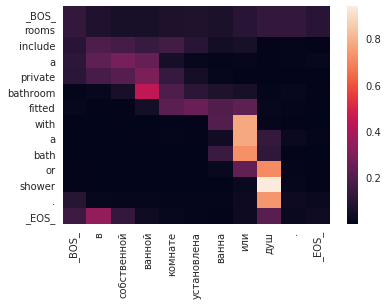

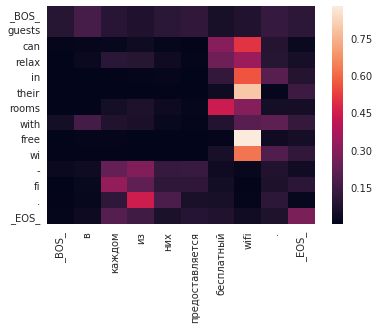

In [117]:
for i in range(len(inp)):
    draw_attention(inp[i], trans[i], attention_probs[i])

In [37]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a common common kitchen and a shared lounge at the guest house .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bicycle rental is also available . other facilities offered and a free parking available on site .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
shanghai of pa@@ wa is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in a peaceful garden , a garden with a terrace and a shared garden , shared kitchen facilities , a quiet location at a furnished terrace . guests can enjoy a quiet beach in cabo frio from barcelona .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
moscow tower is located in moscow avenue square , 200 metres from metro square .

в вашем распоряжении 

## Grand Finale (4+ points)

We want you to find the best model for the task. Use everything you know.

* different recurrent units: rnn/gru/lstm; deeper architectures
* bidirectional encoder, different attention methods for decoder
* word dropout, training schedules, anything you can imagine

As usual, we want you to describe what you tried and what results you obtained.

### Bidirectional 3-layer GRU

Because the training dataset is relatively small in size, 3-layer bidirectional GRU encoder easily overfitted, as can be seen on the chart above. So we need to go with something smaller.

### Bidirectional 1-layer GRU

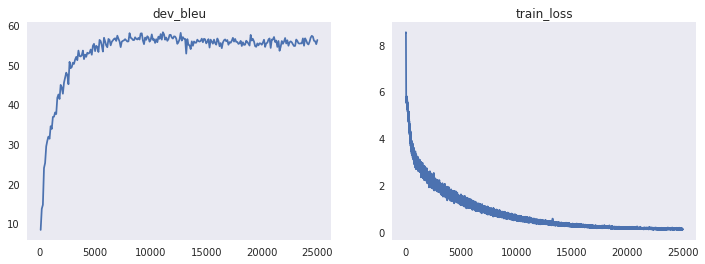

Mean loss=0.106


100%|██████████| 25000/25000 [1:42:29<00:00,  4.07it/s]


In [121]:
# WARNING! this cell will clear your TF graph from the regular model. All trained variables will be gone!
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel('model_attn_v2', inp_voc, out_voc, emb_size=128, hid_size=256, attn_size=256, encoder_num_layers=1)
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])
loss = compute_loss(model, inp, out)
train_step = tf.train.AdamOptimizer().minimize(loss)
metrics = {'train_loss': [], 'dev_bleu': []}
sess.run(tf.global_variables_initializer())
batch_size = 128

for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp[:128], dev_out[:128])))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [122]:
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

56.1490365186087

### Bidirectional 1-layer GRU(lr=1e-4)

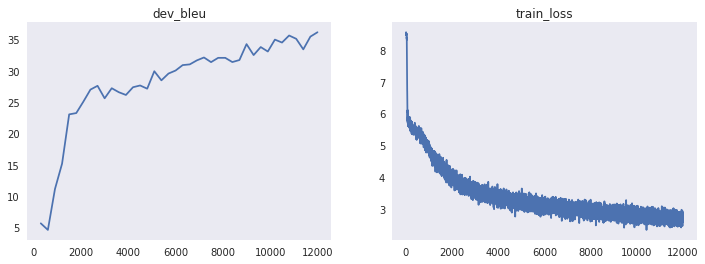

Mean loss=2.724


100%|██████████| 12000/12000 [39:36<00:00,  5.05it/s]


In [123]:
# WARNING! this cell will clear your TF graph from the regular model. All trained variables will be gone!
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel('model_attn_v2', inp_voc, out_voc, emb_size=128, hid_size=256, attn_size=128, encoder_num_layers=1)
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])
loss = compute_loss(model, inp, out)
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
metrics = {'train_loss': [], 'dev_bleu': []}
sess.run(tf.global_variables_initializer())
batch_size = 128

for _ in trange(12000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 300 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp[:128], dev_out[:128])))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


### Bidirectional 1-layer GRU(lr=3e-3)

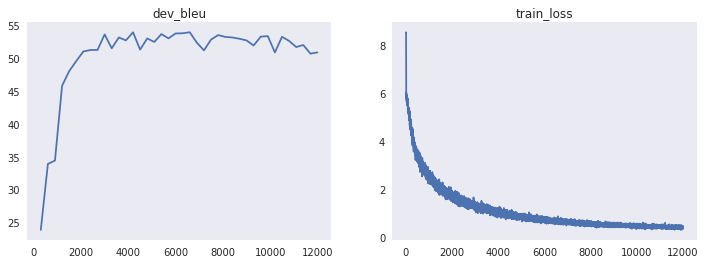

Mean loss=0.390


100%|██████████| 12000/12000 [39:37<00:00,  5.05it/s]


In [125]:
# WARNING! this cell will clear your TF graph from the regular model. All trained variables will be gone!
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel('model_attn_v2', inp_voc, out_voc, emb_size=128, hid_size=256, attn_size=128, encoder_num_layers=1)
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])
loss = compute_loss(model, inp, out)
train_step = tf.train.AdamOptimizer(3e-3).minimize(loss)
metrics = {'train_loss': [], 'dev_bleu': []}
sess.run(tf.global_variables_initializer())
batch_size = 128

for _ in trange(12000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 300 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp[:128], dev_out[:128])))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


### Bidirectional 1-layer GRU(lr=1e-4, early stopping)

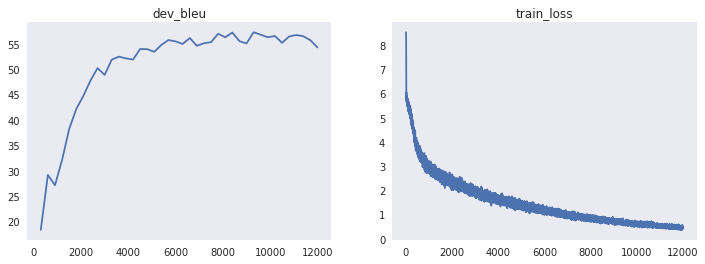

Mean loss=0.461


100%|██████████| 12000/12000 [39:46<00:00,  5.03it/s]


In [126]:
# WARNING! this cell will clear your TF graph from the regular model. All trained variables will be gone!
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel('model_attn_v2', inp_voc, out_voc, emb_size=128, hid_size=256, attn_size=128, encoder_num_layers=1)
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])
loss = compute_loss(model, inp, out)
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
metrics = {'train_loss': [], 'dev_bleu': []}
sess.run(tf.global_variables_initializer())
batch_size = 128

for _ in trange(12000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 300 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp[:128], dev_out[:128])))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [127]:
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

56.17055339494279

### Smaller GRU

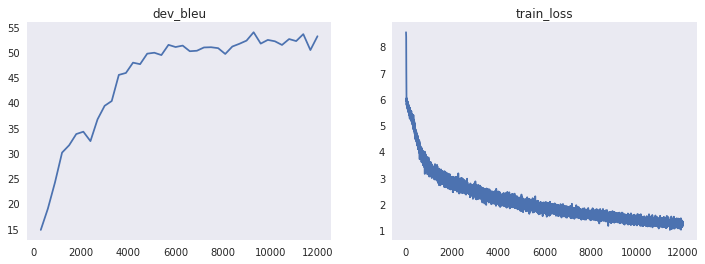

Mean loss=1.242


100%|██████████| 12000/12000 [25:54<00:00,  7.72it/s]


In [129]:
# WARNING! this cell will clear your TF graph from the regular model. All trained variables will be gone!
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel('model_attn_v2', inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=64, encoder_num_layers=1)
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])
loss = compute_loss(model, inp, out)
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
metrics = {'train_loss': [], 'dev_bleu': []}
sess.run(tf.global_variables_initializer())
batch_size = 128

for _ in trange(12000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 300 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp[:128], dev_out[:128])))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [130]:
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

52.35564967726955

### RNN ReLU

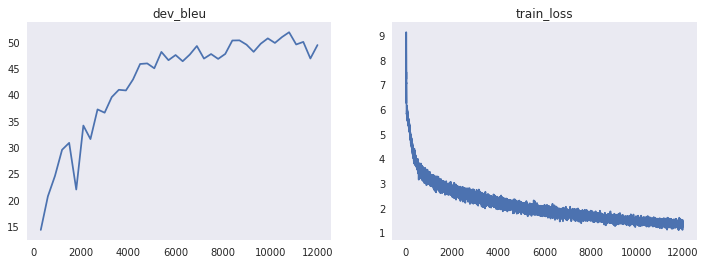

Mean loss=1.354


100%|██████████| 12000/12000 [24:45<00:00,  8.08it/s]


In [135]:
# WARNING! this cell will clear your TF graph from the regular model. All trained variables will be gone!
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel('model_attn_v2', inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=64, encoder_num_layers=1, cell='rnn_relu')
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])
loss = compute_loss(model, inp, out)
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
metrics = {'train_loss': [], 'dev_bleu': []}
sess.run(tf.global_variables_initializer())
batch_size = 128

for _ in trange(12000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 300 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp[:128], dev_out[:128])))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [138]:
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

49.65736553746412

### Results

|Model|dev BLEU|
|--------------|
|Basic model /wo attention|40.56|
|3 BiGRU /w attention|48.71|
|1 BiGRU /w attention|56.14|
|1 BiGRU /w attention, early stopping, lr=1e-4|34.67|
|1 BiGRU /w attention, early stopping, lr=3e-3|52.33|
|**1 BiGRU /w attention, early stopping, lr=1e-3**|**56.18**|
|1 smaller BiGRU /w attention, early stopping|52.35|
|1 smaller RNN relu /w attention, early stopping|49.65|

The results are summarized in the table. The best model turned out to be GRU with attention and early stopping, with 1-layer bidirectional encoder and 1-layer decoder. Larger models otherfitted the training dataset and did not achieve the same BLEU score on dev set.